In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style("white")

In [4]:
(train, test), info = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info= True
)

d:\TeachMe\DATA Sci\IT Högsk\GitHub\Machine_Learning-Mary-Kavalionak\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 100%|██████████| 1/1 [00:20<00:00, 20.28s/ url]


Dataset tf_flowers downloaded and prepared to C:\Users\Mary\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [5]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='C:\\Users\\Mary\\tensorflow_datasets\\tf_flowers\\3.0.1',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [17]:
# label_names = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]

label_names = info.features["label"].names # this is a better way to get the label names

label_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

img shape: (333, 500, 3), label: 2
img shape: (212, 320, 3), label: 3
img shape: (240, 320, 3), label: 3
img shape: (240, 320, 3), label: 4
img shape: (317, 500, 3), label: 3
img shape: (212, 320, 3), label: 0
img shape: (240, 240, 3), label: 0
img shape: (333, 500, 3), label: 0


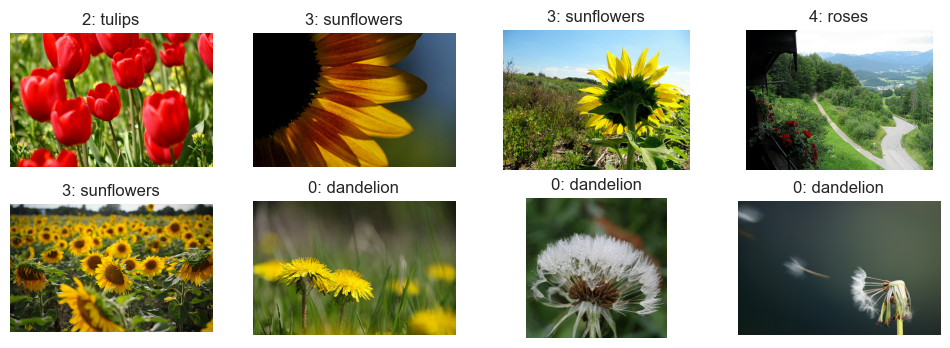

In [9]:
fig, axes = plt.subplots(2,4, figsize = (12,4))

for i, img_sample in enumerate(train.take(8)):
    print(f"img shape: {img_sample[0].shape}, label: {img_sample[1]}")
    ax = axes.flatten()[i]
    ax.imshow(img_sample[0])
    ax.set_title(f"{img_sample[1]}: {label_names[img_sample[1]]}")
    ax.axis("off")

### Preprocessing

N.B. Images are typically represented in 8-bit integers, where pixel values range from 0 to 255.
Dividing by 255 scales these values to a range of 0 to 1.

In [10]:
def preprocess_images(img, label, img_shape = (120, 120)):
    img = tf.image.resize(img, img_shape)/255.0
    return img, label

input_shape = 120, 120, 3
batch_size = 32

# prefetch always gets one batch of data ready 
# GPu work on backpropagation and forward propagation while CPU works on preprocessing a batch
# buffer size is the number of images to shuffle
train_batch = train.shuffle(buffer_size=600).map(preprocess_images).batch(batch_size).prefetch(1) 
test_batch = test.map(preprocess_images).batch(batch_size).prefetch(1)

test_batch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Transfer learning

The approach which is used in this lecture note is:

    - Load a model which has been pretrained on a large dataset e.g. imagenet.
    - Remove the top, i.e. the classifier part and MLP part
    - Freeze the layers weights of the pretrained network. Reason for this is to use the pretrained weights to extract feature maps from new images which it hasn't seen before.
    - Add an MLP part and classifier part. Train the data on the last part.

Idea behind this is that we can reuse a network that is trained on large dataset as many kernels such as edge detectors, simple shape detectors can be used on other datasets as well. Also this is cheap as it is more data-expensive and computationally expensive to train a large network from scratch.

However some deeper layers extract more and more complicated structures that may be too specific for another dataset. Then another approach is to use the shallower layers for feature extraction and train the new dataset on the deeper layers to fine-tune the network. Then add an MLP part as in above.


In [11]:
from tensorflow.keras.applications import Xception

feature_extractor = Xception(weights = "imagenet", include_top = False, input_shape = (input_shape))
feature_extractor.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 59, 59,    │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 59, 59,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 59, 59,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 57, 57,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 57, 57,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 57, 57,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 57, 57,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 57, 57,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 57, 57,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 57, 57,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 57, 57,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 29, 29,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 29, 29,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 29, 29,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 29, 29,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 29, 29,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

model = Sequential(
    [
        feature_extractor,
        GlobalAveragePooling2D(), # reduce the number of parameters
        Dropout(0.5),
        Dense(256, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(5, activation="softmax"),
    ]
)

for layer in feature_extractor.layers:
    layer.trainable = False
    
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,309 (81.59 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [13]:
model.fit(train_batch, epochs = 20, validation_data = test_batch)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 851ms/step - acc: 0.5658 - loss: 1.1592 - val_acc: 0.8052 - val_loss: 0.5663
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 920ms/step - acc: 0.7532 - loss: 0.6551 - val_acc: 0.8338 - val_loss: 0.5143
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 863ms/step - acc: 0.7920 - loss: 0.5653 - val_acc: 0.8324 - val_loss: 0.4878
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 76s 830ms/step - acc: 0.8195 - loss: 0.5020 - val_acc: 0.8447 - val_loss: 0.4587
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 844ms/step - acc: 0.8212 - loss: 0.4989 - val_acc: 0.8202 - val_loss: 0.4862
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 987ms/step - acc: 0.8473 - loss: 0.4350 - val_acc: 0.8447 - val_loss: 0.4412
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 889ms/step - acc: 0.8438 - loss: 0.4262 - val_acc: 0.8488 - val_loss: 0.4487
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 889ms/step - acc: 0.8532 - loss: 0.3886 - val_acc: 0.8324 - val_loss: 0.4605
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 90s 983ms/

In [14]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,acc,loss,val_acc,val_loss
0,0.650204,0.933599,0.805177,0.566329
1,0.757153,0.656046,0.833787,0.514319
2,0.792916,0.569164,0.832425,0.487760
3,0.814033,0.511338,0.844687,0.458657
4,0.820163,0.484129,0.820163,0.486202


<Axes: >

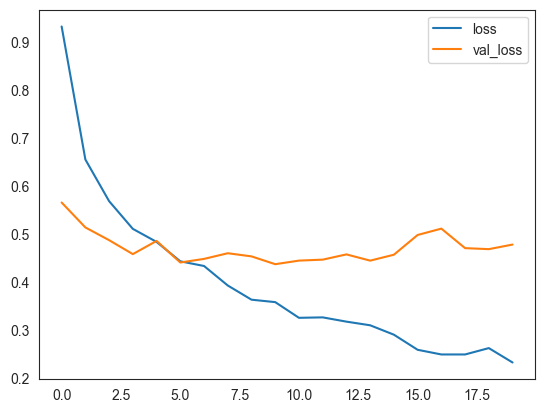

In [15]:
metrics[["loss", "val_loss"]].plot()

<Axes: >

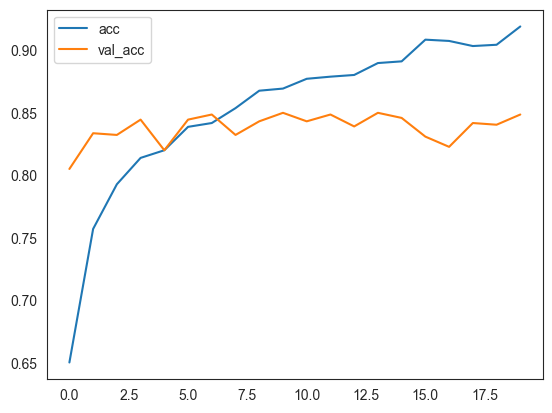

In [16]:
metrics[["acc", "val_acc"]].plot()